We will look at the performance of Pnet against:
 - an equally sparse but randomly connected feed forward neural network (sparseNN)
 - a fully connected feed forward neural network (fcNN)
 - a random forest classifier model (RF)
 - a svm classifier model (SVM)

The benchmarking task is done on the original prostate dataset from the 2019 paper

### Loading the data

In [1]:
import pnet_loader
import util
import Pnet
import torch
import random
import seaborn as sns
import pandas as pd
import os
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC


%load_ext autoreload
%autoreload 2

In [2]:
prostate_mutations = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/P1000_final_analysis_set_cross_important_only.csv')
prostate_mutations.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_cnv = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/P1000_data_CNA_paper.csv')
prostate_cnv.rename(columns={"Unnamed: 0": "Tumor_Sample_Barcode"}, inplace=True)
prostate_cnv.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_response = pd.read_csv('/mnt/disks/pancan/pnet_database/prostate/processed/response_paper.csv')
prostate_response.rename(columns={'id': "Tumor_Sample_Barcode"}, inplace=True)
prostate_response.set_index('Tumor_Sample_Barcode', inplace=True)

prostate_genes = pd.read_csv('/mnt/disks/pancan/pnet_database/genes/tcga_prostate_expressed_genes_and_cancer_genes.csv')
prostate_genes = list(set(prostate_genes['genes']).intersection(set(prostate_mutations.columns)).intersection(set(prostate_cnv.columns)))

# prostate_mutations = pd.read_csv('../../data/pnet_database/prostate/processed/P1000_final_analysis_set_cross_important_only.csv')
# prostate_mutations.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_cnv = pd.read_csv('../../data/pnet_database/prostate/processed/P1000_data_CNA_paper.csv')
# prostate_cnv.rename(columns={"Unnamed: 0": "Tumor_Sample_Barcode"}, inplace=True)
# prostate_cnv.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_response = pd.read_csv('../../data/pnet_database/prostate/processed/response_paper.csv')
# prostate_response.rename(columns={'id': "Tumor_Sample_Barcode"}, inplace=True)
# prostate_response.set_index('Tumor_Sample_Barcode', inplace=True)

# prostate_genes = pd.read_csv('../../data/pnet_database/genes/tcga_prostate_expressed_genes_and_cancer_genes.csv')
# prostate_genes = list(set(prostate_genes['genes']).intersection(set(prostate_mutations.columns)).intersection(set(prostate_cnv.columns)))

prostate_cnv = prostate_cnv[prostate_genes].copy()
prostate_mutations = prostate_mutations[prostate_genes].copy()

# prostate_genes = util.select_highly_variable_genes(prostate_mutations)
# prostate_genes = prostate_genes['level_1']
prostate_mutations = prostate_mutations[list(set(prostate_mutations.columns).intersection(prostate_genes))].copy()
prostate_cnv = prostate_cnv[list(set(prostate_cnv.columns).intersection(prostate_genes))].copy()

# Regenerate input as specified in prostate_paper
prostate_mutations = (prostate_mutations > 0).astype(int)
prostate_amp = (prostate_cnv > 1).astype(int)
prostate_del = (prostate_cnv < -1).astype(int)

genetic_data = {'mut': prostate_mutations, 'amp': prostate_amp, 'del': prostate_del}

Generate train test splits for 10 fold CV, not to run again if saved splits are available

In [3]:
# prostate_inds = pnet_loader.get_indicies(genetic_data, prostate_response)
# random.shuffle(prostate_inds)

# def chunks(lst, n):
#     """Yield successive n-sized chunks from lst."""
#     for i in range(0, len(lst), n):
#         yield lst[i:i + n]
        
# test_splits = chunks(prostate_inds, int(len(prostate_inds)/10)+1)
# for i, s in enumerate(test_splits):
#     train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, prostate_response, test_inds=s)
#     train_dataset.save_indicies('../data/splits/train_set_{}.csv'.format(i))
#     test_dataset.save_indicies('../data/splits/test_set_{}.csv'.format(i))

Found 1011 overlapping indicies


In [46]:
# from sklearn.model_selection import StratifiedKFold

# prostate_inds = pnet_loader.get_indicies(genetic_data, prostate_response)
# y = list(prostate_response.loc[prostate_inds]['response'])
# # Assuming `y` contains the labels for your training data
# # and `prostate_inds` contains the indices of the training data
# # Make sure `y` and `prostate_inds` have the same length

# # Create an instance of StratifiedKFold with 10 splits
# skf = StratifiedKFold(n_splits=10)

# # Initialize an empty list to store the sublists of indices
# sublists = []

# # Split the indices into sublists stratified by labels
# for train_index, _ in skf.split(prostate_inds, y):
#     sublist = [prostate_inds[i] for i in train_index]
#     sublists.append(sublist)
    
# for i, s in enumerate(sublists):
#     s_ = [x for x in prostate_inds if x not in s]
#     train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, prostate_response, train_inds=s, test_inds=s_)
#     train_dataset.save_indicies('../data/splits/train_set_{}.csv'.format(i))
#     test_dataset.save_indicies('../data/splits/test_set_{}.csv'.format(i))

Found 1011 overlapping indicies
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (909, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (102, 14562)
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (910, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (101, 14562)
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (910, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (101, 14562)
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (910, 14562)
Initializing Test Data

Pnet performance:

Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (909, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (102, 14562)
Found 4854 overlapping genes
We are sending to cuda
Hit early stopping criteria
torch.Size([102, 1])
doing binary
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (910, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (101, 14562)
Found 4854 overlapping genes
We are sending to cuda
Hit early stopping criteria
torch.Size([101, 1])
doing binary
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (910, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size

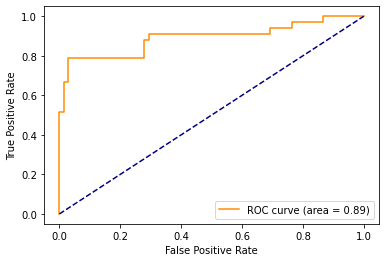

In [47]:
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, prostate_response, seed=0, dropout=0.2, lr=1e-3, weight_decay=1,
                                                                           batch_size=64, epochs=300, early_stopping=True, train_inds=train_inds,
                                                                           test_inds=test_inds)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val/run{}'.format(i))

Pnet but with random gene and pathway connections:

In [48]:
pnet_aucs = []
for i in range(10):
    auc = torch.load('../results/prostate_val/run{}/AUC.pt'.format(i))
    pnet_aucs.append(auc.item())
pnet_aucs

[0.879325270652771,
 0.8906936049461365,
 0.897278368473053,
 0.9024063944816589,
 0.874331533908844,
 0.8761141300201416,
 0.8480392098426819,
 0.8199643492698669,
 0.8778965473175049,
 0.8894830942153931]

In [50]:
torch.tensor(pnet_aucs).median()

tensor(0.8779)

Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (909, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (102, 14562)
Found 4854 overlapping genes
We are sending to cuda
Hit early stopping criteria
torch.Size([102, 1])
doing binary
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (910, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (101, 14562)
Found 4854 overlapping genes
We are sending to cuda
Hit early stopping criteria
torch.Size([101, 1])
doing binary
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (910, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size

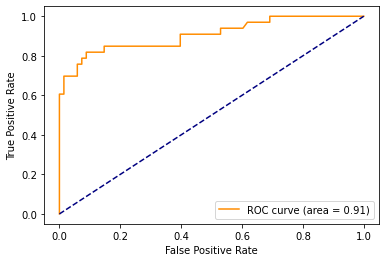

In [51]:
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, prostate_response, seed=0, dropout=0.2, lr=1e-3, weight_decay=1,
                                                                           batch_size=64, epochs=300, early_stopping=True, train_inds=train_inds,
                                                                           test_inds=test_inds, random_network=True)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val_random_net/run{}'.format(i))

Pnet but as a fully connected feed forward neural network:

Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (909, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (102, 14562)
Found 4854 overlapping genes
We are sending to cuda
Hit early stopping criteria
torch.Size([102, 1])
doing binary
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (910, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (101, 14562)
Found 4854 overlapping genes
We are sending to cuda
Hit early stopping criteria
torch.Size([101, 1])
doing binary
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (910, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size

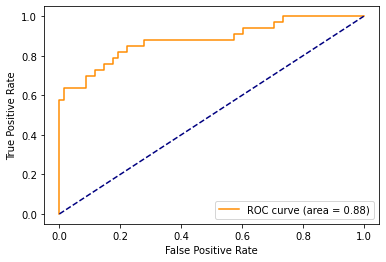

In [52]:
for i in range(10):
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data, prostate_response, seed=0, dropout=0.2, lr=1e-3, weight_decay=1,
                                                                           batch_size=64, epochs=300, early_stopping=True, train_inds=train_inds,
                                                                           test_inds=test_inds, fcnn=True)
    plt.clf()
    Pnet.evaluate_interpret_save(model, test_dataset, '../results/prostate_val_fcnn/run{}'.format(i))

Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (909, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (102, 14562)
torch.Size([102, 2])
Getting multiclass AUC as One vs. Rest
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (910, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (101, 14562)
torch.Size([101, 2])
Getting multiclass AUC as One vs. Rest
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (910, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (101, 14562)
torch.Size([101, 2])
Getting multiclass AUC as One vs. Rest
Given 3 Input modalities
Found 101

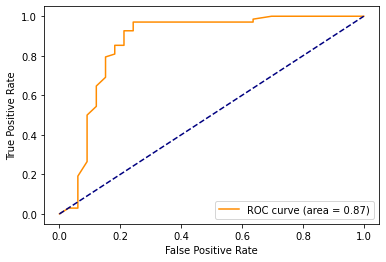

In [53]:
for i in range(10):
    path = '../results/prostate_val_rf/run{}'.format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target=prostate_response, train_inds=train_inds, test_inds=test_inds)
    
    x_train = train_dataset.x
    additional_train = train_dataset.additional
    y_train = train_dataset.y.ravel()
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y.ravel()
    
    rfc = RandomForestClassifier(max_depth=None, random_state=0)
    rfc.fit(x_train, y_train)
    preds = rfc.predict(x_test)
    preds_prob = rfc.predict_proba(x_test)
    plt.clf()
    auc = util.get_auc(torch.tensor(preds_prob, dtype=torch.float), y_test, save=path+'/auc_curve.pdf')
    importances = rfc.feature_importances_
    forest_importances = pd.Series(importances, index=test_dataset.input_df.columns)
    forest_importances.to_csv(path+'/gene_feature_importances.csv')
    torch.save(auc, path+'/AUC.pt')
    

Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (909, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (102, 14562)
torch.Size([102, 2])
Getting multiclass AUC as One vs. Rest
14562
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (910, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (101, 14562)
torch.Size([101, 2])
Getting multiclass AUC as One vs. Rest
14562
Given 3 Input modalities
Found 1011 overlapping indicies
Initializing Train Dataset
Found 4854 overlapping genes
generated input DataFrame of size (910, 14562)
Initializing Test Dataset
Found 4854 overlapping genes
generated input DataFrame of size (101, 14562)
torch.Size([101, 2])
Getting multiclass AUC as One vs. Rest
14562
Given 3 Input mo

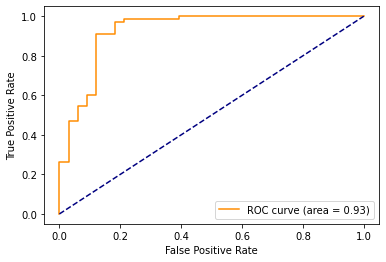

In [54]:
for i in range(10):
    path = '../results/prostate_val_svm/run{}'.format(i)
    if not os.path.exists(path):
        os.makedirs(path)
    train_inds = list(pd.read_csv('../data/splits/train_set_{}.csv'.format(i))['indicies'])
    test_inds = list(pd.read_csv('../data/splits/test_set_{}.csv'.format(i))['indicies'])
    train_dataset, test_dataset = pnet_loader.generate_train_test(genetic_data, target=prostate_response, train_inds=train_inds, test_inds=test_inds)
    
    x_train = train_dataset.x
    additional_train = train_dataset.additional
    y_train = train_dataset.y.ravel()
    x_test = test_dataset.x
    additional_test = test_dataset.additional
    y_test = test_dataset.y.ravel()
    
    svm = SVC(gamma='auto', kernel='linear', probability=True)
    svm.fit(x_train, y_train)
    
    preds = svm.predict(x_test)
    preds_prob = svm.predict_proba(x_test)
    plt.clf()
    auc = util.get_auc(torch.tensor(preds_prob, dtype=torch.float), y_test, save=path+'/auc_curve.pdf')
    importances = svm.coef_
    print(len(importances[0]))
    svm_importances = pd.Series(importances[0], index=test_dataset.input_df.columns)
    svm_importances.to_csv(path+'/gene_feature_importances.csv')
    torch.save(auc, path+'/AUC.pt')
    